# 案例：股票收益率预测——LSTM


接上一节内容，本节使用长短期记忆模型（LSTM）来回归股票收益率序列。

In [1]:
import pandas as pd
X_train = pd.read_csv('datasets/X_train.csv', index_col=0)
X_test = pd.read_csv('datasets/X_test.csv', index_col=0, date_format='%Y%m%d')
y_train = pd.read_csv('datasets/y_train.csv', index_col=0)
y_test = pd.read_csv('datasets/y_test.csv', index_col=0)

In [2]:
X_train.index = pd.to_datetime(X_train.index)
X_test.index = pd.to_datetime(X_test.index)
y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)

## 7. 深度学习模型——LSTM

现在让我们为 LSTM 模型准备数据集。我们需要所有输入变量和输出变量的数组形式的数据。

LSTM 背后的逻辑是，数据取自前 $n$ 天（当天相关资产的所有其他特征数据和 MSFT 的滞后变量），我们尝试预测第二天。然后，我们将窗口移动一天，再次预测第二天。我们对整个数据集进行这样的重复（当然是分批进行）。

初始化模型的训练集和测试集：

In [24]:
import numpy as np
seq_len = 10                    # 窗口长度
feature_n = X_train.shape[1]
# 单个样本的大小为 seq_len * feature_n
X_train_LSTM = np.zeros((X_train.shape[0], seq_len, feature_n))  
y_train_LSTM = np.zeros((X_train.shape[0], feature_n))  
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, feature_n))  
y_test_LSTM = np.zeros((X_test.shape[0], feature_n))  

In [25]:
X_train_LSTM.shape, y_train_LSTM.shape

((540, 10, 11), (540, 11))

In [26]:
for i in range(X_train.shape[0]-seq_len):
    X_train_LSTM[i, :, :] = X_train.iloc[i:i+seq_len,:]
    y_train_LSTM[i] = y_train.iloc[i+seq_len]

In [27]:
for i in range(X_test.shape[0]-seq_len):
    X_test_LSTM[i, :, :] = X_test.iloc[i:i+seq_len,:]
    y_test_LSTM[i] = y_test.iloc[i+seq_len]

调用keras库的LSTM模型

In [28]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.optimizers.legacy import SGD, Adam 
from keras.layers import LSTM

In [29]:
input_shape=(seq_len, feature_n)
output_units = feature_n      

In [30]:
model = Sequential()
model.add(LSTM(20, activation='relu',
               input_shape=input_shape,
               return_sequences=True))
model.add(LSTM(20, activation='relu'))
model.add(Dense(output_units))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

下面开始训练模型，

In [31]:
model_fit = model.fit(X_train_LSTM, y_train_LSTM,
                      validation_data=(X_test_LSTM,y_test_LSTM),
                      epochs=100,
                      batch_size=50,
                      verbose=1,
                      shuffle=False)

Epoch 1/100
11/11 [==============================] - 1s 16ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 11

现在，我们用数据拟合 LSTM 模型，同时在训练集和测试集中观察模型性能指标随时间的变化：

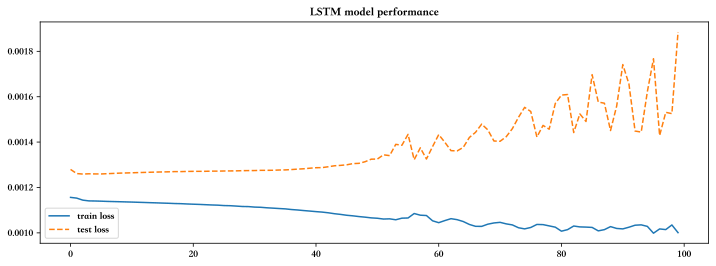

In [32]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Songti SC'  # 设置字体为宋体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号“-”显示异常
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 

plt.figure(figsize=(12,4))
plt.plot(model_fit.history['loss'], label='train loss', )
plt.plot(model_fit.history['val_loss'], '--',label='test loss',)
plt.title('LSTM model performance')
plt.legend(loc='lower left')
plt.show()

随着训练的轮数增加，训练集和测试集的误差在同步下降。

## 8. 模型对比

In [35]:
train_results, test_results, names = [], [], []
# LR
train_results.append(0.001146)
test_results.append(0.00129)

# ARIMA
train_results.append(0.001139)
test_results.append(0.001246)

# LSTM
train_results.append(0.0010)
test_results.append(0.0013)

names.append("LR")
names.append("ARIMA")
names.append("LSTM")

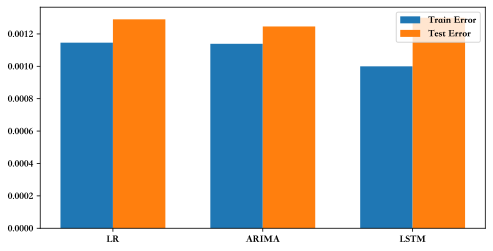

In [36]:
ind = np.arange(len(names))
width = 0.35
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
plt.bar(ind-width/2, train_results, width=width, label='Train Error')
plt.bar(ind+width/2, test_results, width=width, label='Test Error')
plt.xticks(ind)
ax.set_xticklabels(names)
plt.legend()
plt.show()

## 结论

本案例研究将利用3种（LR、ARIMA、LSTM）模型，结合股票的相关资产及其自身历史数据，来预测其股票价格。本案例研究，提供了股票预测建模的一般机器学习方法，涵盖从数据收集和清理，到构建和调整不同模型的整个过程。研究发现，LSTM代表的非线性模型在训练误差和测试误差，相比于线性模型（LR、ARIMA）均有较好的表现。